# Full SLAV-seq analysis

Requires the following to be run 

```bash
snakemake map --cores {cores} --use-conda --rerun-incomplete --show-failed-logs
snakemake call --cores {cores} --use-conda --rerun-incomplete --show-failed-logs
```

and results stored in `../results/`

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pyranges as pr
from tqdm import tqdm
from joblib import Parallel, delayed
from scripts.get_labels import read_knrgl, read_rmsk, label_windows, filter_windows

In [44]:
# read donor table
donors = pd.read_csv("../config/all_donors.tsv", sep="\t")
donors["diagnosis"] = donors["diagnosis"].apply(
    lambda x: "Neurotypical" if x == "CONTROL" else "Schizophrenia"
)

## Inspect CommonBrain labels

In [66]:
# read in annotations
sv_blacklist = pr.read_bed("../resources/sv_blacklist.bed").df
segdups = pr.read_bed("../resources/segdups.bedpe").df
rmsk = read_rmsk("/iblm/netapp/data4/mcuoco/sz_slavseq/resources/hs38d1.fa.out")
knrgl = read_knrgl(
    "/iblm/netapp/data4/mcuoco/sz_slavseq/resources/CommonBrain_insertions.bed"
)

In [71]:
# read in feature tables
features = Path(
    "/iblm/logglun02/mcuoco/workflows/sz_slavseq/results/model/get_features/CommonBrain"
).rglob("*pqt")

df = pd.concat([pd.read_parquet(f) for f in features])
df = df.loc[df["cell_id"] != "plate2_E7_S101"].reset_index(drop=True)
df = df.loc[df["total_reads"] >= 3, :]

# label the windows
df = label_windows(df, rmsk, "rmsk")
df = label_windows(df, knrgl, "knrgl")

label = []
for row in df.itertuples():
    if row.knrgl:
        label.append("KNRGL")
    elif row.rmsk:
        label.append("RMSK")
    else:
        label.append("OTHER")

df.drop(["knrgl", "rmsk"], axis=1, inplace=True)
df["label"] = label

In [88]:
df.drop(["sv_blacklist", "segdups"], axis=1, inplace=True)

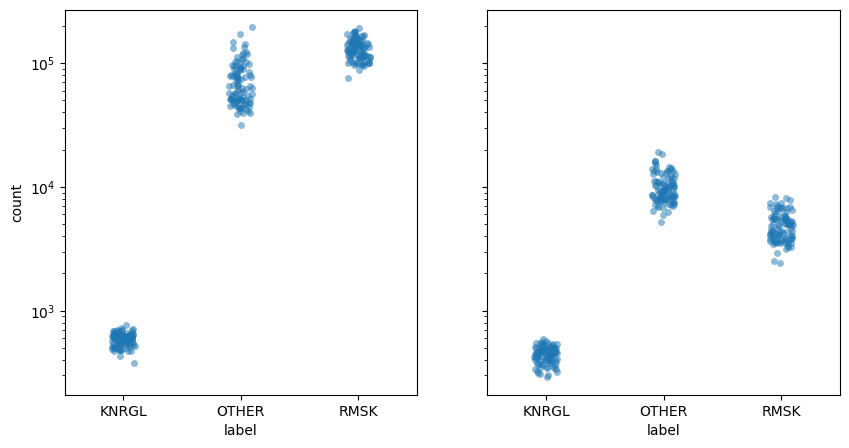

In [89]:
old_df = (
    df.groupby(["label", "cell_id"]).size().reset_index().rename({0: "count"}, axis=1)
)
new_df = filter_windows(df, sv_blacklist, segdups)
new_df = (
    new_df.groupby(["label", "cell_id"])
    .size()
    .reset_index()
    .rename({0: "count"}, axis=1)
)

# make subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# plot the old windows
sns.stripplot(data=old_df, x="label", y="count", ax=axes[0], alpha=0.5)
axes[0].set_yscale("log")

# plot the new windows
sns.stripplot(data=new_df, x="label", y="count", ax=axes[1], alpha=0.5)
axes[1].set_yscale("log")

## Test SLAVseq model on other individuals

In [93]:
import pickle as pkl
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay

In [91]:
# load model
with open(
    "/iblm/logglun02/mcuoco/workflows/sz_slavseq/results/model/train/model.pkl", "rb"
) as f:
    clf = pkl.load(f)

/iblm/netapp/data2/mcuoco/conda/envs/shell/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SimpleImputer from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/iblm/netapp/data2/mcuoco/conda/envs/shell/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SimpleImputer from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/iblm/netapp/data2/mcuoco/conda/envs/shell/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator ColumnTransformer from version 1.0.2 when using

testing CommonBrain
testing 35
testing 27
testing 28
testing 24
testing 46
testing 32
testing 8


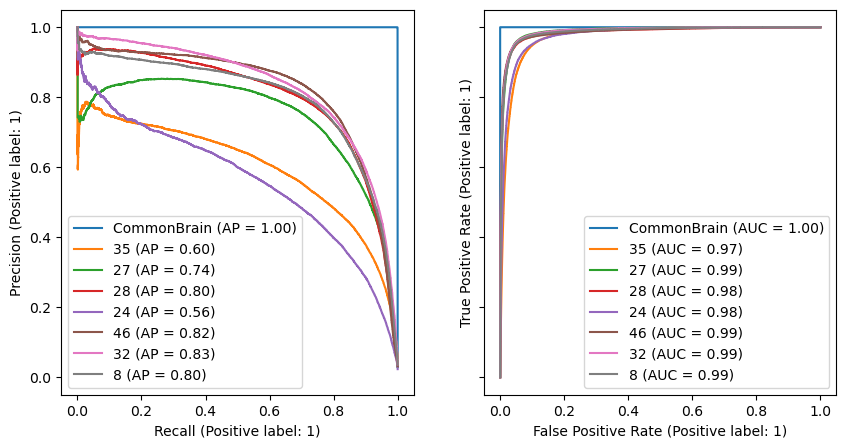

In [101]:
# make subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for f in Path(
    "/iblm/logglun02/mcuoco/workflows/sz_slavseq/results/model/get_labels"
).rglob("*pqt"):
    donor_id = f.name.rstrip(".pqt")
    print(f"testing {donor_id}")
    df = pd.read_parquet(f)

    # encode labels
    df["label_encoded"] = df["label"].map({"OTHER": 0, "KNRGL": 1})

    PrecisionRecallDisplay.from_estimator(
        clf.model.estimator,
        df[clf.feature_names_in_],
        df["label_encoded"],
        name=donor_id,
        ax=axes[0],
    )

    RocCurveDisplay.from_estimator(
        clf.model.estimator,
        df[clf.feature_names_in_],
        df["label_encoded"],
        name=donor_id,
        ax=axes[1],
    )

## Examine L1 insertion calls

In [ ]:
samplesheet = pd.read_csv("../../config/all_samples.tsv", sep="\t")

In [ ]:
# define helper functions
def merge_windows(df):
    """Groupby apply function to merge overlapping windows with same prediction"""

    # get best prediction (highest probability)
    best_proba = df.KNRGL_proba.max()
    best_windows = df.KNRGL_proba == best_proba

    # take window(s) with best prediction
    df = df.loc[best_windows, :]

    # if there is only one window, return it
    if type(df) == pd.Series:
        d = {
            "Chromosome": df.Chromosome,
            "Start": df.Start,
            "End": df.End,
            "proba": df.KNRGL_proba,
        }
    else:
        d = {
            "Chromosome": df.Chromosome.unique()[0],
            "Start": df.Start.min(),
            "End": df.End.max(),
            "proba": df.KNRGL_proba.mean(),
        }
    return pd.Series(d)


def get_predictions(f):
    """Load predictions from parquet file and merge overlapping windows with same prediction"""

    # load predictions
    d = pd.read_parquet(f)
    d = d.loc[d["pred"] == "KNRGL", :]

    if d.shape[0] == 0:
        return pd.DataFrame()

    # merge overlapping windows with KNRGL prediction
    d = (
        pr.PyRanges(d)
        .cluster()
        .df.groupby("Cluster")
        .apply(merge_windows)
        .reset_index()
        .drop(["Cluster"], axis=1)
    )

    # save KNRGL predictions
    d["cell_id"] = f.name.rstrip(".pqt")
    d["donor_id"] = f.parent.name

    return d

In [ ]:
# parallelize for speed, takes <1 min with n_jobs=20
total = len(
    list(Path("../../results/model/predict/").rglob("*pqt"))
)  # get total for tqdm progress bar
res = Parallel(n_jobs=20)(
    delayed(get_predictions)(f)
    for f in tqdm(Path("../../results/model/predict/").rglob("*pqt"), total=total)
)
res = pd.concat(res)

In [ ]:
cells = (
    res.groupby("donor_id")
    .apply(lambda x: pr.PyRanges(x).cluster().df)
    .reset_index(drop=True)
    .groupby(["donor_id", "Cluster"])
    .apply(lambda x: x["cell_id"].nunique())
    .sort_values(ascending=False)
    .rename("n_cells")
    .reset_index()
)

In [ ]:
# log scale
cells.hist("n_cells", bins=100, log=True)